In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import time
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
from pylab import rcParams
import seaborn as sb

%matplotlib inline
rcParams['figure.figsize'] = 15, 16
sb.set_style('whitegrid')

## Import dataset

In [3]:
address = './datasets/staandelamp_realistic_huge.json'
df_data = pd.read_json(address)

# Sort the data on timestamp
df_data = df_data.sort_values(by=['time'])

print(df_data.shape)
df_data.head()

(175000, 3)


,name,state,time
1,Staande_Lamp_2,1,1509490125797
2,Staande_Lamp_3,1,1509490363420
0,Staande_Lamp_1,0,1509491964532
6,Staande_Lamp_5,1,1509492113970
4,Staande_Lamp_3,0,1509492126316


#####  Cut off the dataset

In [4]:
df_data = df_data[:42]
# df_data = df_data[:40000]

# Determine the number of clusters (linkage)

#### only interested in column TIME

In [5]:
X = df_data.iloc[ :, [2] ].values
#                 :        All the rows
#                    [2]   Only column 2 (time)

X[:5]

array([[1509490125797],
       [1509490363420],
       [1509491964532],
       [1509492113970],
       [1509492126316]], dtype=int64)

##### Plot the timestamps and a line indicating 5 minutes

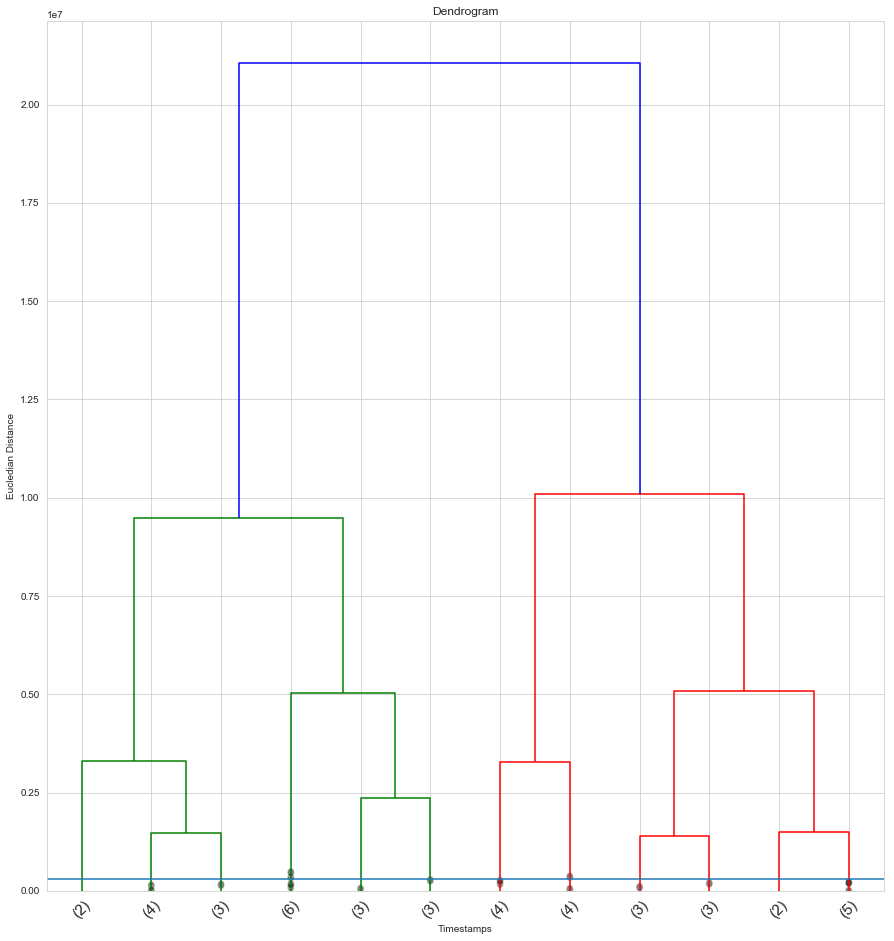

In [6]:
Z = linkage(X, method='complete')

gram = dendrogram(
    Z, 
    labels=X,
    truncate_mode='lastp', 
    p=12, 
    leaf_rotation=45., 
    leaf_font_size=15., 
    show_contracted=True
)
plt.title('Dendrogram')
plt.xlabel('Timestamps')
plt.ylabel('Eucledian Distance')

# This line represents a distance of 5 minutes
plt.axhline(y=300000)

In [7]:
five_minutes = 300000

clusters_with_distance_of_five_minutes_or_less = 0
for idx, val in enumerate(Z):
    if(val[2] < five_minutes): 
        clusters_with_distance_of_five_minutes_or_less += 1

In [8]:
total_number_of_clusters = Z.shape[0]
print(
    clusters_with_distance_of_five_minutes_or_less, 
    'of', 
    total_number_of_clusters, 
    'clusters have a distance less than 5 minutes'
)

20 of 41 clusters have a distance less than 5 minutes


# AgglomerativeClustering

##### Format the dataset to be all numbers

In [9]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

print('before:\n', df_data.head())

d = defaultdict(LabelEncoder)
df_fit = df_data.apply(lambda x: d[x.name].fit_transform(x))
df_fit['time'] = df_data['time']
print('after:\n', df_fit.head())

before:
              name  state           time
1  Staande_Lamp_2      1  1509490125797
2  Staande_Lamp_3      1  1509490363420
0  Staande_Lamp_1      0  1509491964532
6  Staande_Lamp_5      1  1509492113970
4  Staande_Lamp_3      0  1509492126316
after:
    name  state           time
1     1      1  1509490125797
2     2      1  1509490363420
0     0      0  1509491964532
6     4      1  1509492113970
4     2      0  1509492126316


In [10]:
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm

model = AgglomerativeClustering(
    affinity='euclidean', 
    compute_full_tree='auto',
    connectivity=None, 
    linkage='complete', 
    memory=None, 
    n_clusters=clusters_with_distance_of_five_minutes_or_less,
    pooling_func='deprecated'
)

In [11]:
predicted_clusters = model.fit(df_fit).labels_
predicted_clusters

array([ 6,  6,  1,  1,  1,  1, 17, 16, 16,  3,  3, 14,  8,  8,  8,  2,  2,
        2, 19, 13, 13,  0,  0,  0, 12, 15, 15, 11, 11, 10, 10,  7,  7,  7,
        4,  4,  5,  5,  5,  9,  9, 18], dtype=int64)

##### Find outliers

In [12]:
outlier_dict = {}
for i in model.labels_: 
    outlier_dict[i] = i in outlier_dict
outliers = [k for k in outlier_dict if not outlier_dict[k]]

print('outliers:\n', outliers)

outliers:
 [17, 14, 19, 12, 18]


### Make a color map for all groups and outliers (for plotting)

In [13]:
COLOR_MAP = {}
group_count = 0;
for n in set(model.labels_):
    if n in outliers:
        COLOR_MAP[n] = 'lightgrey'
    else:
        group_count += 1
        if group_count % 7 == 0:
            COLOR_MAP[n] = 'firebrick'
        elif group_count % 7 == 1:
            COLOR_MAP[n] = 'darkgreen'
        elif group_count % 7 == 2:
            COLOR_MAP[n] = 'purple'
        elif group_count % 7 == 3:
            COLOR_MAP[n] = 'darkorange'
        elif group_count % 7 == 4:
            COLOR_MAP[n] = 'Teal'
        elif group_count % 7 == 5:
            COLOR_MAP[n] = 'Olive'
        elif group_count % 7 == 6:
            COLOR_MAP[n] = 'Green'
        else:
            COLOR_MAP[n] = 'darkblue'

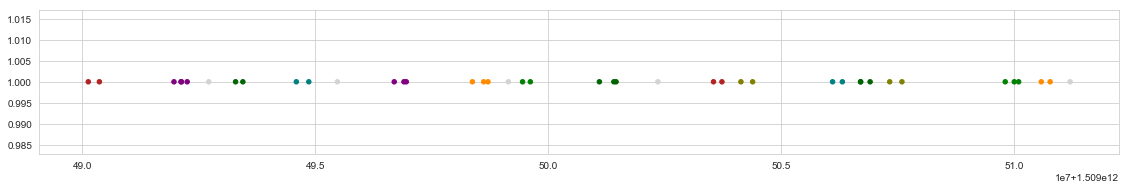

In [14]:
rcParams['figure.figsize'] = 15, 2
fig = plt.figure()
ax = fig.add_axes([.1, .1, 1, 1])
colors = [COLOR_MAP[l] for l in model.labels_]
XX = df_fit.iloc[:,2]
YY = [1] * df_fit.shape[0]
ax.scatter(XX, YY, c=colors, s=20)